# “Machine Learning and Computational Statistics”: Project

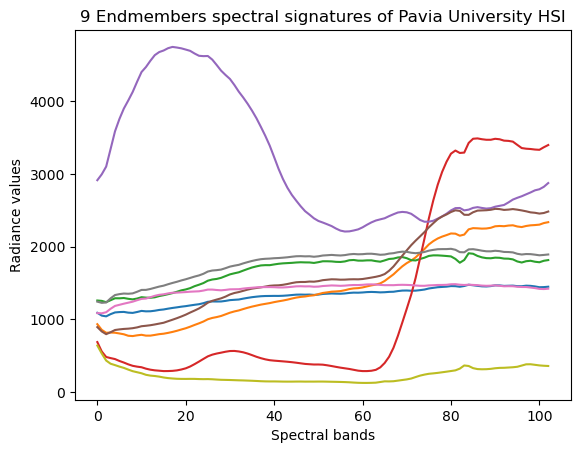

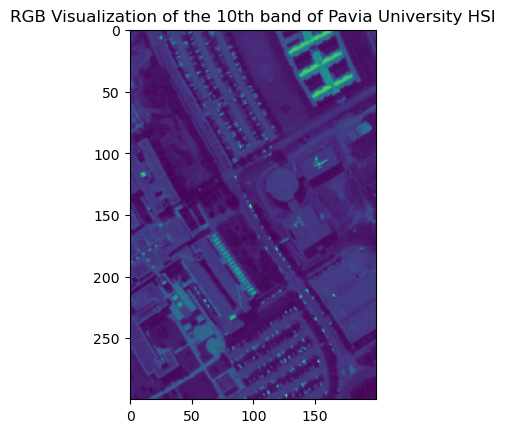

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import Lasso
from scipy.optimize import nnls
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()

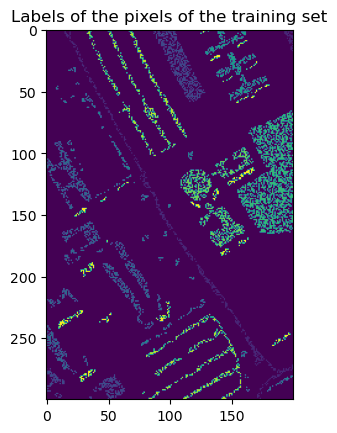

In [2]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [3]:
# Getting matrices' shapes
print(f"Endmembers: {endmembers.shape[0]} x {endmembers.shape[1]}")
print(f"HSI: {HSI.shape[0]} x {HSI.shape[1]} X {HSI.shape[2]}")

Endmembers: 103 x 9
HSI: 300 x 200 X 103


## Part 1 (spectral unmixing)

### (a) Least squares

In [4]:
# Initializing table to save parameters (9 paramaters per pixel 300x200)
theta_LS = np.empty((300, 200, 9))

# Iterate through each pixel
for i in range(300):
    for j in range(200):
        if (labels[i,j] != 0):
# Use LS to calculate 9 paramaters (1 for each material) for pixel i,j -> save in theta matrix 
            theta_LS[i, j, :] = np.linalg.inv((endmembers).T@(endmembers))@(endmembers.T)@(HSI[i,j,:])     

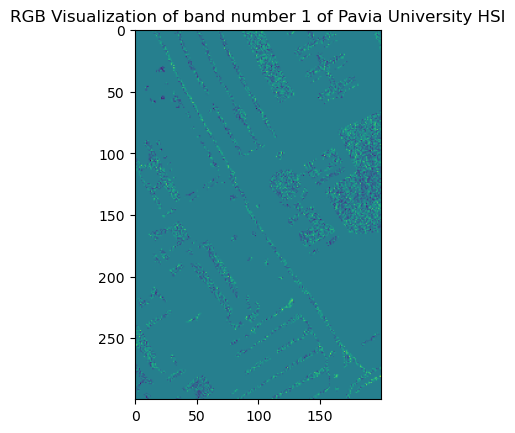

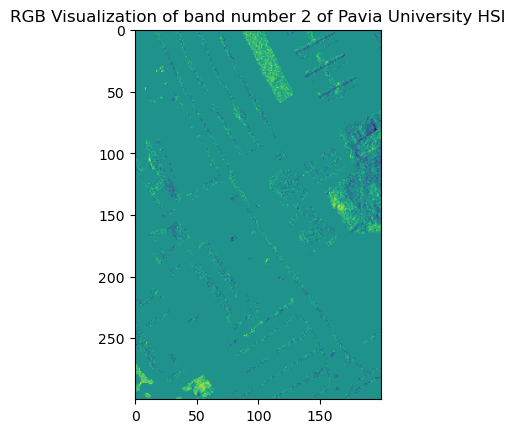

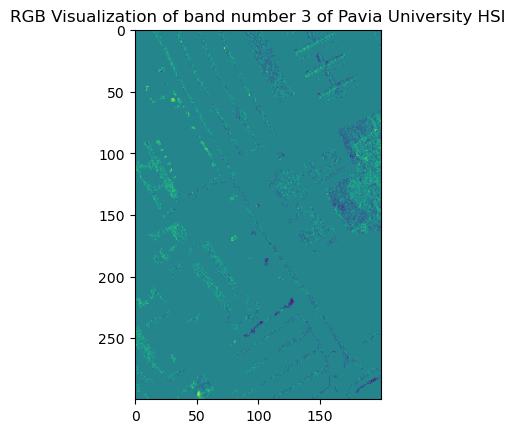

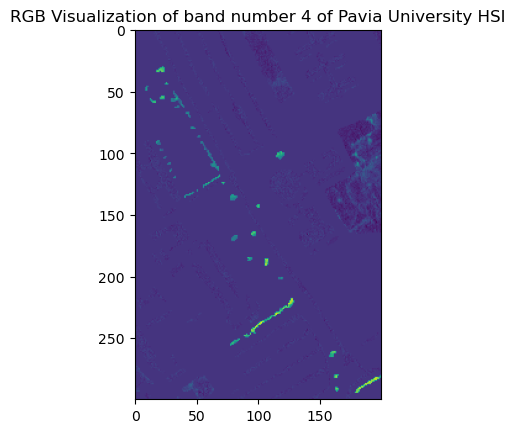

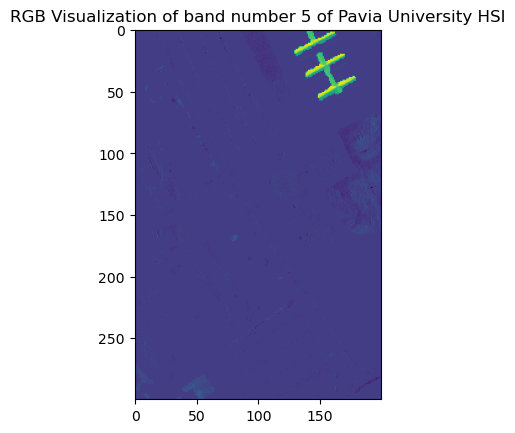

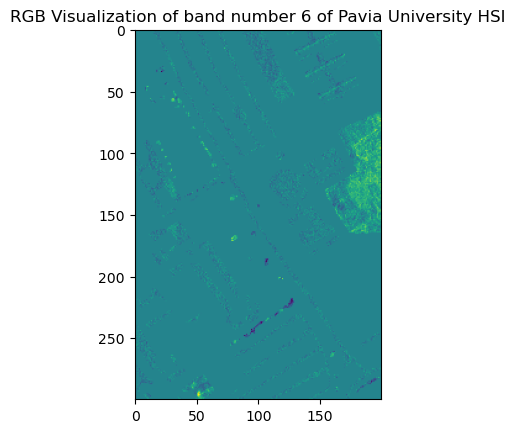

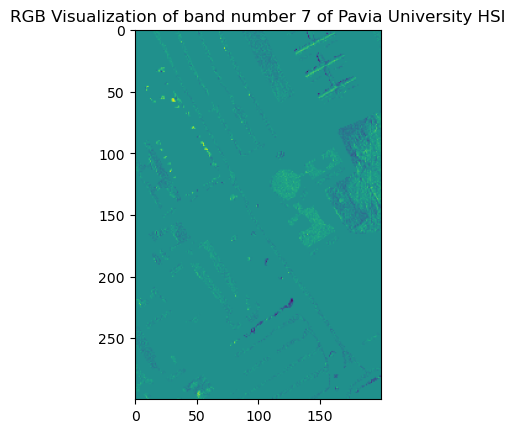

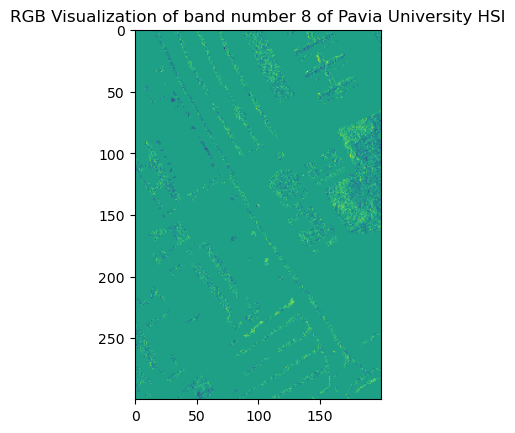

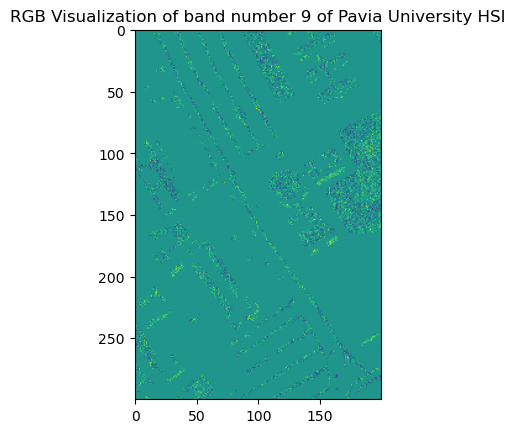

In [5]:
# For each of the nine materials print the abundance map (slice i of theta matrix)
for i in range(9):
    fig = plt.figure()
    plt.imshow(theta_LS[:,:,i])
    plt.title(f'RGB Visualization of band number {i+1} of Pavia University HSI')
    plt.show()

In [6]:
# Compute the error ||yi - XΘi||^2
LS_error = 0
count = 0
for i in range(300):
    for j in range(200):
        if labels[i,j] != 0:
            yi = HSI[i,j,:]
            est = endmembers@theta_LS[i,j,:]
            squared_distance = np.sum((yi - est) ** 2)
            LS_error += squared_distance
            count += 1
LS_error = LS_error/count
print(f"Error for spectral unmixing using ordinary least square method: {LS_error}")

Error for spectral unmixing using ordinary least square method: 118783.18062626586


### (b) Least squares imposing the sum-to-one constraint

In [7]:
# Constraint for the sum of the parameters (equal to 1)
def constraint_function(A):
    return np.sum(A) - 1

# Minimize XΘ = y
def objective_function(A, X, y):
    residual = np.dot(X, A) - y
    return np.sum(residual**2)

# Combined objective function with parameter constraint
def combined_objective(A, X, y):
    return objective_function(A, X, y) + lambda_coefficient * constraint_function(A)**2

# Initialize param matrix
theta_s1LS = np.empty((300, 200, 9))
s1LS_error = 0
count = 0
for i in range(300):
    for j in range(200):
        if labels[i,j] != 0:
            initial_guess = np.ones(9) / 9  # Equal weights as the initial guess
            constraint = {'type': 'eq', 'fun': constraint_function}
            lambda_coefficient = 1.0
            result = minimize(combined_objective, initial_guess, args=(endmembers, HSI[i,j,:]), constraints=constraint)
            theta_s1LS[i,j,:] = result.x
            yi = HSI[i,j,:]
            est = endmembers@theta_s1LS[i,j,:]
            squared_distance = np.sum((yi - est) ** 2)
            s1LS_error += squared_distance
            count += 1
s1LS_error = s1LS_error/count
print(f"Error for spectral unmixing using least square method with sum to 1 constraint: {s1LS_error}")

Error for spectral unmixing using least square method with sum to 1 constraint: 160049.93067625887


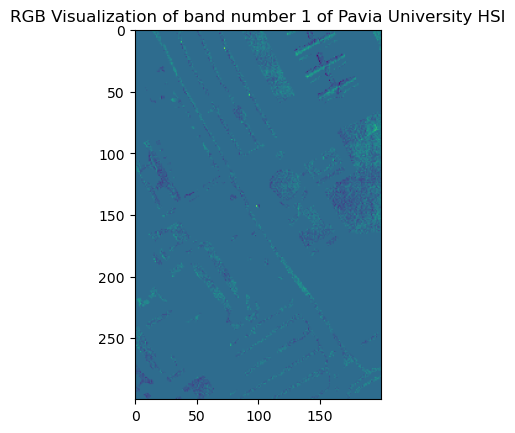

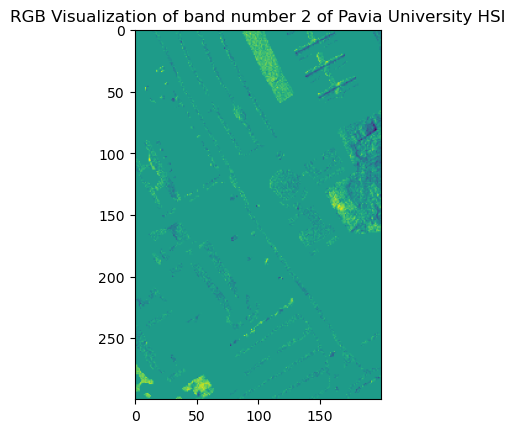

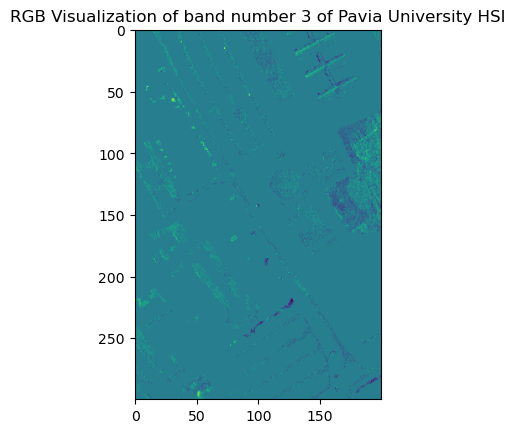

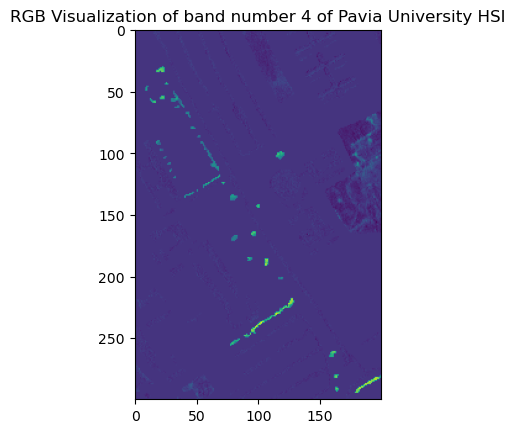

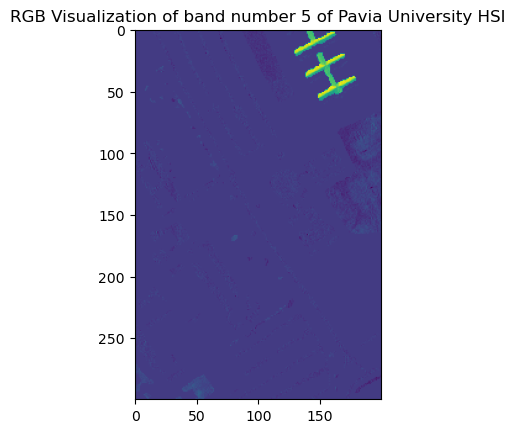

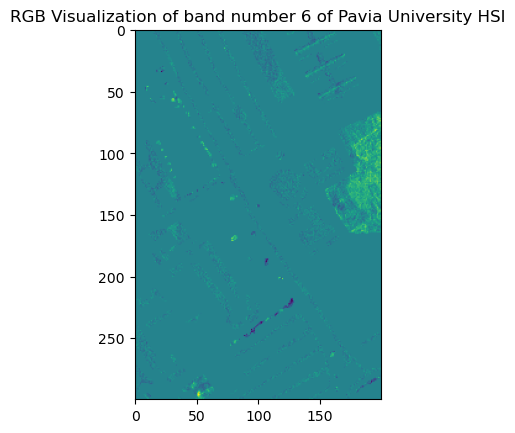

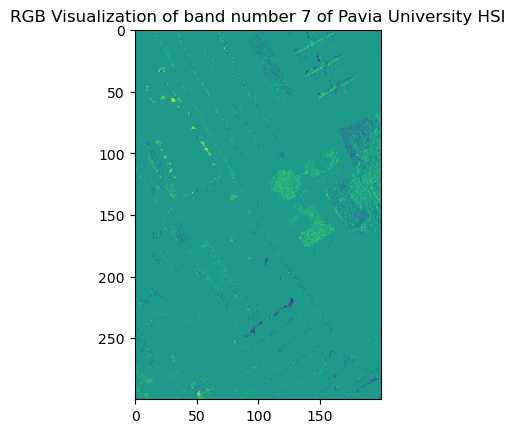

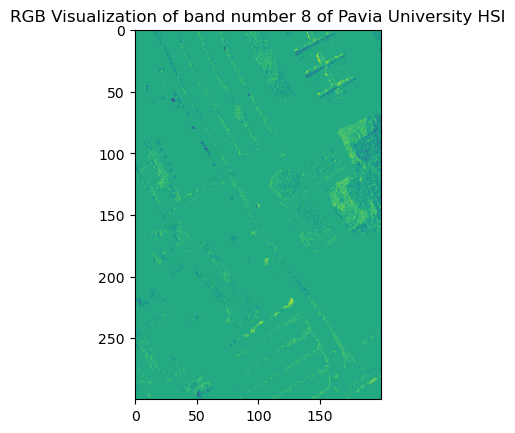

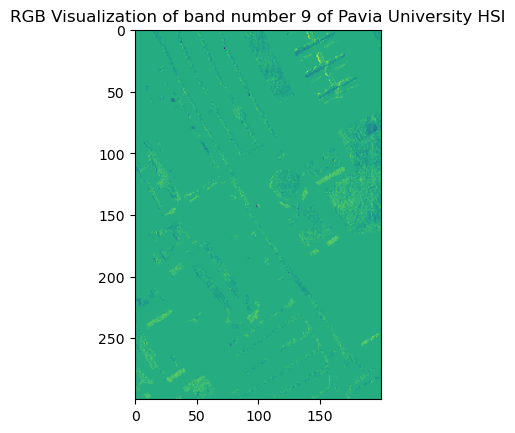

In [8]:
for i in range(9):
    fig = plt.figure()
    plt.imshow(theta_s1LS[:,:,i])
    plt.title(f'RGB Visualization of band number {i+1} of Pavia University HSI')
    plt.show()

### (c) Least squares imposing the non-negativity constraint on the entries of θ

In [9]:
theta_nnLS = np.empty((300, 200, 9))
nnLS_error = 0
count = 0
for i in range(300):
    for j in range(200):
        if labels[i,j] != 0:
            reg_nnls = nnls(endmembers,HSI[i,j,:])
            theta_nnLS[i,j,:] = reg_nnls[0]
            yi = HSI[i,j,:]
            est = endmembers@theta_nnLS[i,j,:]
            squared_distance = np.sum((yi - est) ** 2)
            nnLS_error += squared_distance
            count += 1
nnLS_error = nnLS_error/count
print(f"Error for spectral unmixing using least square method with non-negative parameters constraint: {nnLS_error}")

Error for spectral unmixing using least square method with non-negative parameters constraint: 569339.291056418


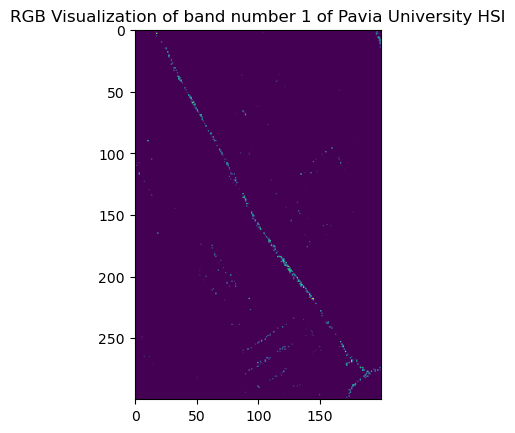

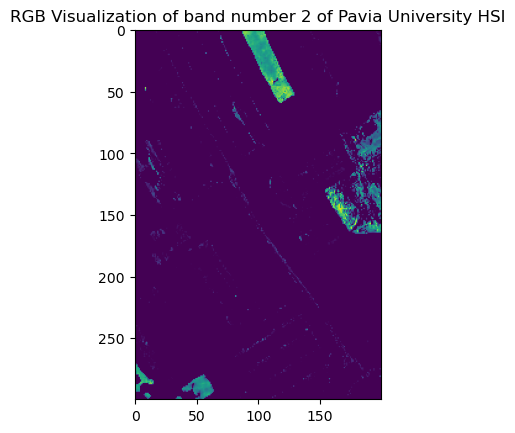

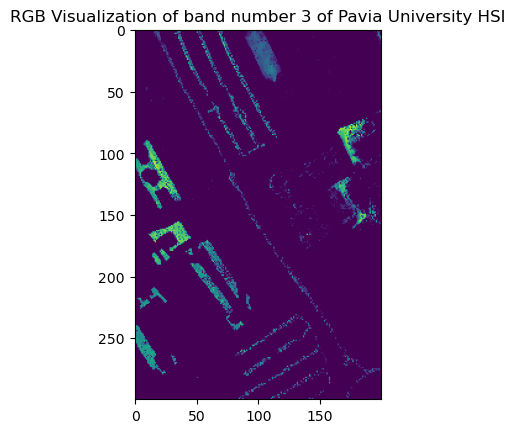

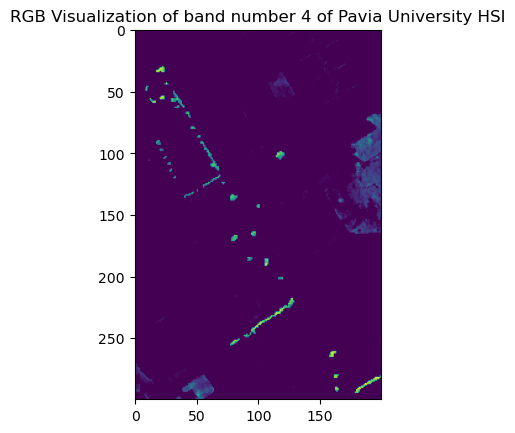

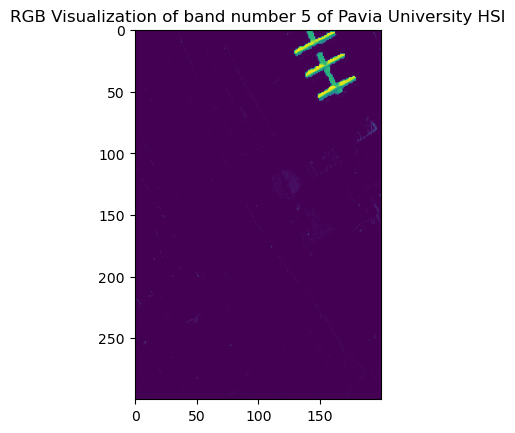

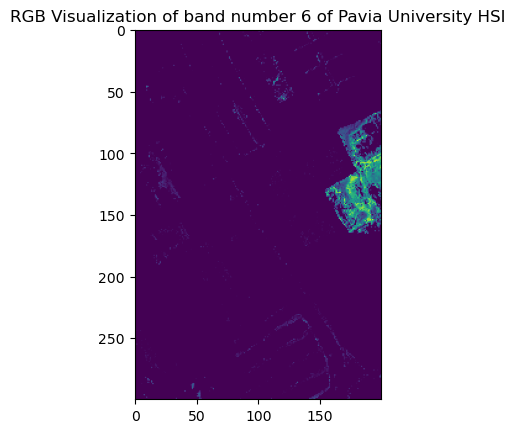

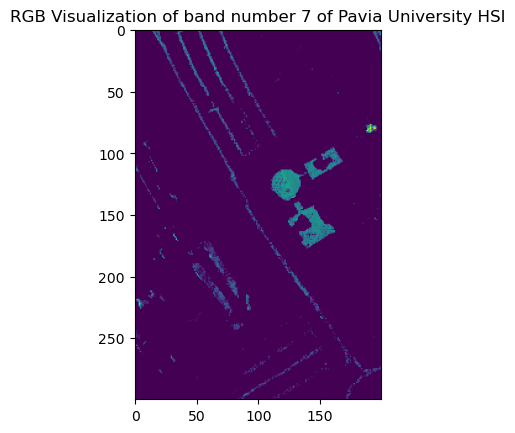

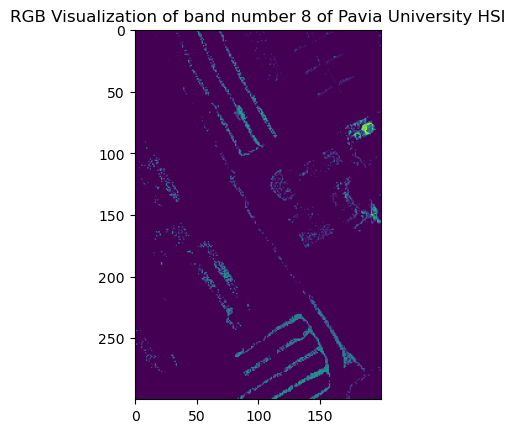

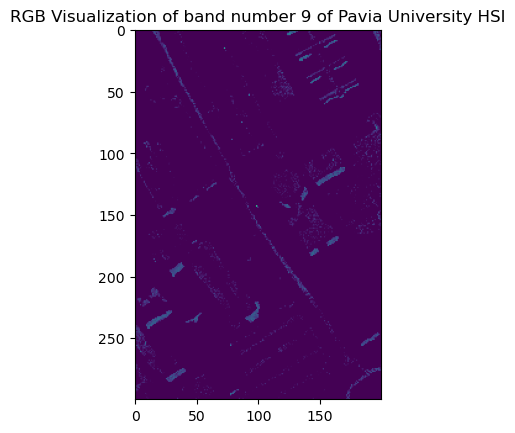

In [10]:
for i in range(9):
    fig = plt.figure()
    plt.imshow(theta_nnLS[:,:,i])
    plt.title(f'RGB Visualization of band number {i+1} of Pavia University HSI')
    plt.show()

### (d) Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ.

In [11]:
def constraint_function(A):
    return np.sum(A) - 1


def objective_function(A, X, y):
    residual = np.dot(X, A) - y
    return np.sum(residual**2)

def combined_objective(A, X, y):
    return objective_function(A, X, y) + lambda_coefficient * constraint_function(A)**2

theta_s1nnLS = np.empty((300, 200, 9))
s1nnLS_error = 0
count = 0
bounds = [(0, None)] * 9 # Add bound for non-negativity to sum to 1 constraint problem.
for i in range(300):
    for j in range(200):
        if labels[i,j] != 0:
            initial_guess = np.ones(9) / 9  # Equal weights as the initial guess
            constraint = {'type': 'eq', 'fun': constraint_function}
            lambda_coefficient = 1.0
            result = minimize(combined_objective, initial_guess, args=(endmembers, HSI[i,j,:]),bounds=bounds, constraints=constraint)
            theta_s1nnLS[i,j,:] = result.x
            yi = HSI[i,j,:]
            est = endmembers@theta_s1nnLS[i,j,:]
            squared_distance = np.sum((yi - est) ** 2)
            s1nnLS_error += squared_distance
            count += 1
s1nnLS_error = s1nnLS_error/count
print(f"Error for spectral unmixing using least square method with both non-negative parameters and sum to 1 constraint: {s1nnLS_error}")

Error for spectral unmixing using least square method with both non-negative parameters and sum to 1 constraint: 52905640.76460193


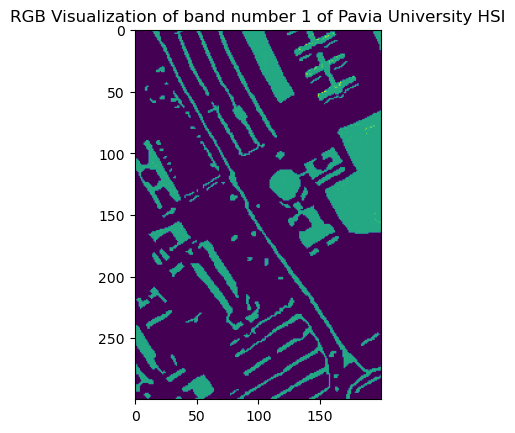

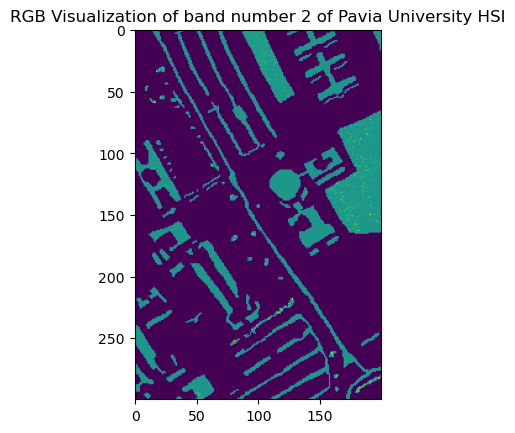

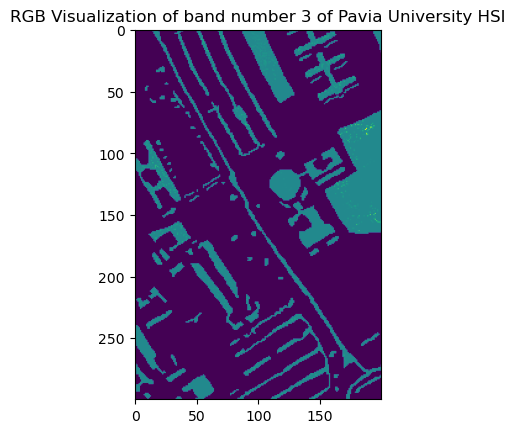

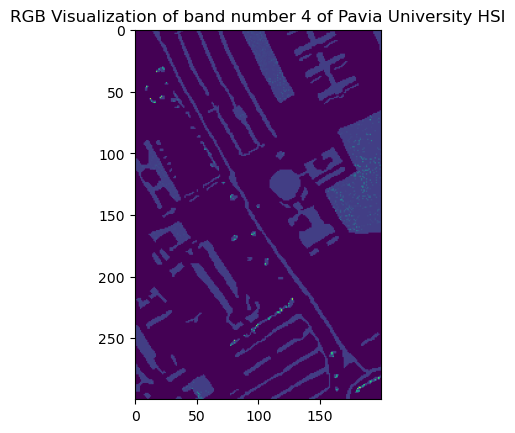

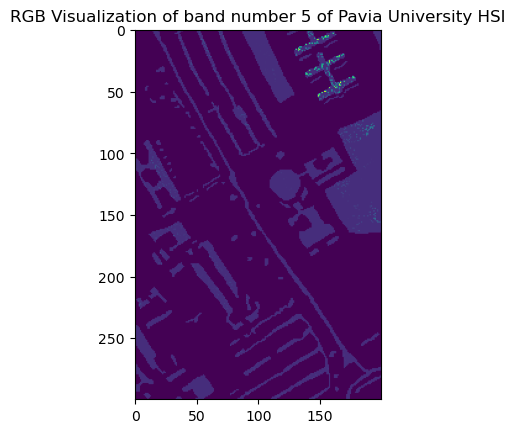

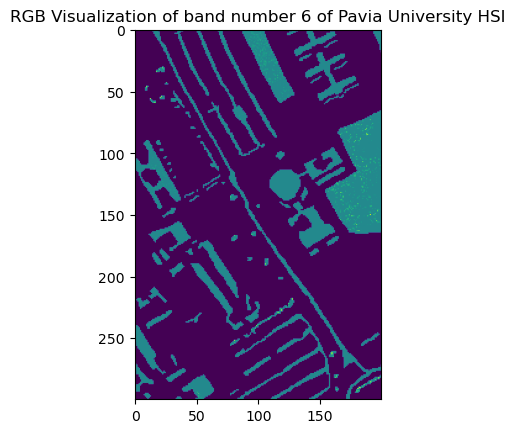

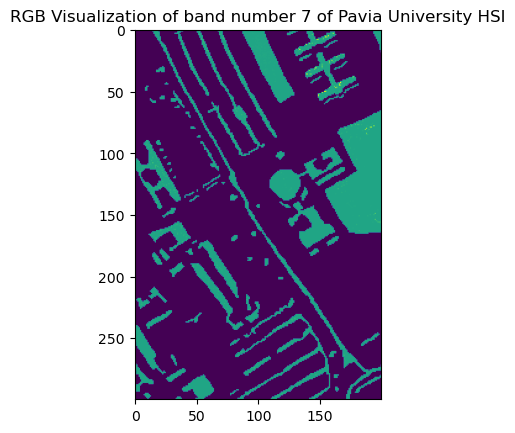

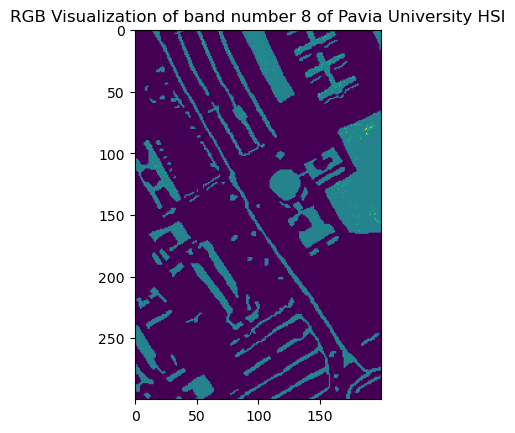

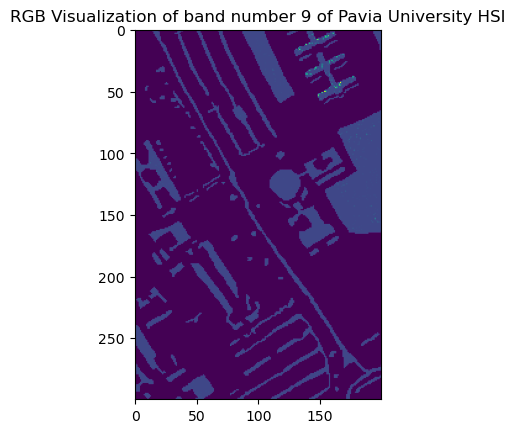

In [12]:
for i in range(9):
    fig = plt.figure()
    plt.imshow(theta_s1nnLS[:,:,i])
    plt.title(f'RGB Visualization of band number {i+1} of Pavia University HSI')
    plt.show()

### (e) LASSO, i.e., impose sparsity on θ via 𝑙1 norm minimization.


In [13]:
theta_Lasso = np.empty((300, 200, 9))
LassoLS_error = 0
count = 0
for i in range(300):
    for j in range(200):
        if labels[i,j] != 0:
            alpha = 0.1
            lasso_reg = Lasso(alpha=alpha)
            lasso_reg.fit(endmembers, HSI[i,j,:])
            theta_Lasso[i,j,:] = lasso_reg.coef_
            yi = HSI[i,j,:]
            est = endmembers@theta_Lasso[i,j,:]
            squared_distance = np.sum((yi - est) ** 2)
            LassoLS_error += squared_distance
            count += 1
LassoLS_error = LassoLS_error/count
print(f"Error for spectral unmixing using LASSO: {LassoLS_error}")

Error for spectral unmixing using LASSO: 183437800.0098242


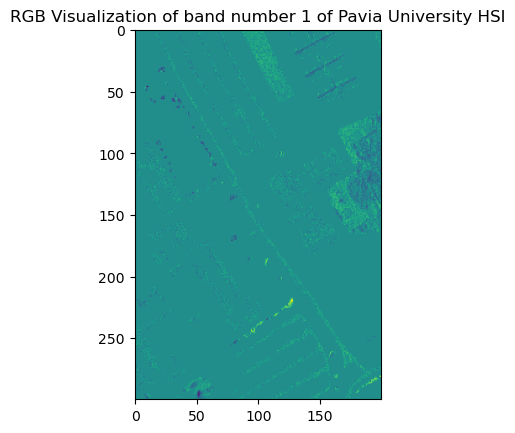

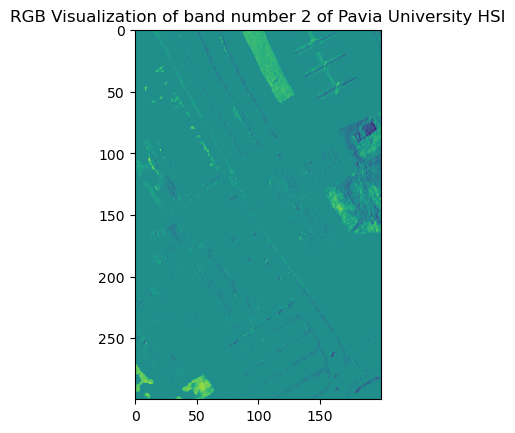

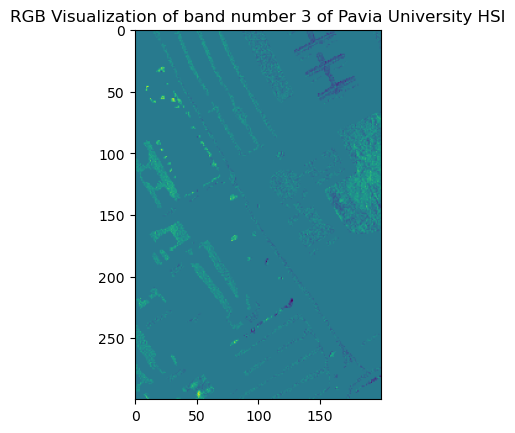

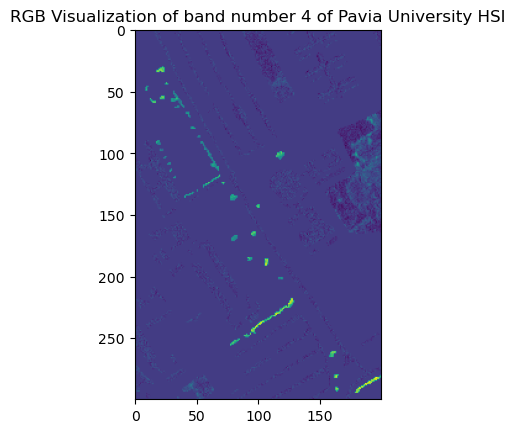

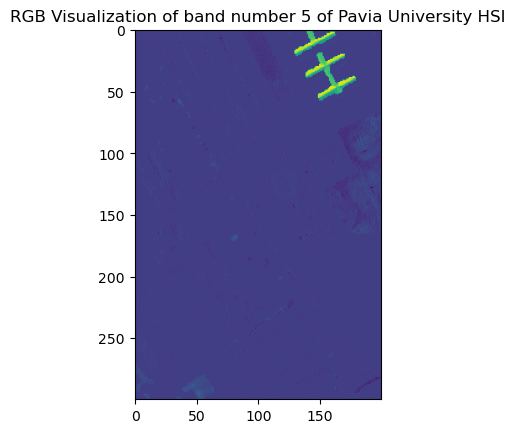

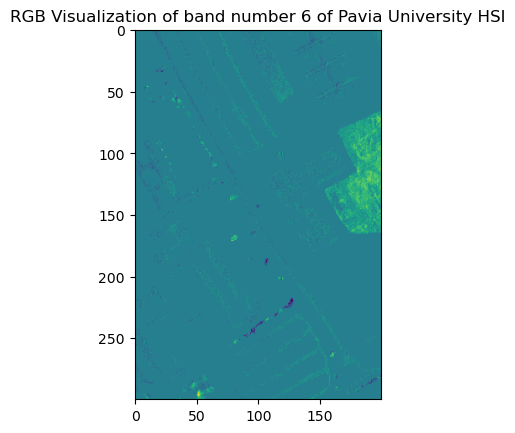

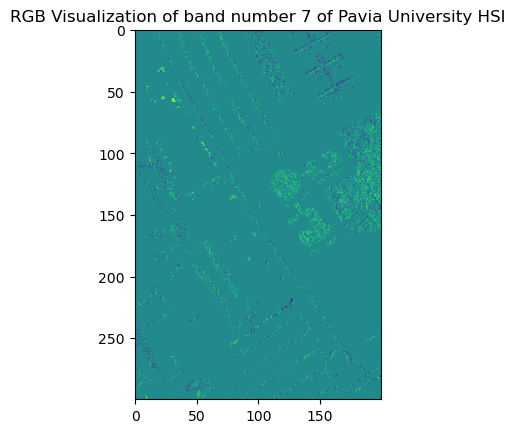

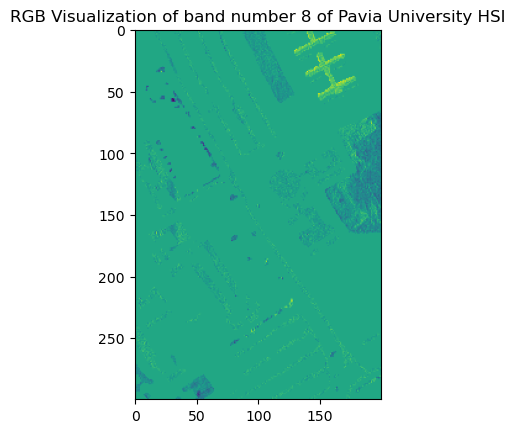

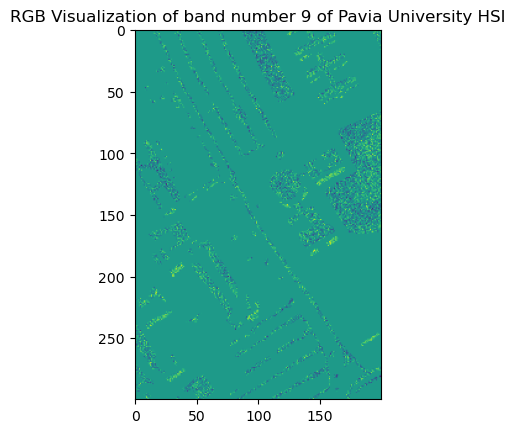

In [14]:
for i in range(9):
    fig = plt.figure()
    plt.imshow(theta_Lasso[:,:,i])
    plt.title(f'RGB Visualization of band number {i+1} of Pavia University HSI')
    plt.show()

## (B) Compare the results obtained from the above five methods 

To successfully compare the above 5 methods, firstly we need to rank them based on their reconstruction error. The best reconstruction error was from the ordinary LS method, with 118783, followed by LS(sum-to-1) with 160049 and LS(non-negative) with 569339. The errors for the other 2 methods, LS(S1-NN) and LASSO were extremely high, with 52 and 193 million respectivelly. The first thing we observe is that with the adding of constraints, the error becomes larger, something normal as the global minimum of the loss function is not found and a local minimum of the constraint region is kept. We can see that constraining the parameters to be summed to 1 gave us significantly less error than the non-negativity constraint and a relatively close error to the ordinary LS method. If we look at the abundance maps (that picture the theta values-want to see clear distinction of objects of the material from each band) for the ordinary LS, we can see that there is no clear distinction of the materials of each band, except from band 5, and all the pictures have an almost smooth green color for all the pixels. If we look at the LS(sum-to-1) maps, we can see a better distinction of materials for more bands. Still, some of the pictures keep the all green format, showing no distinct materials, but there is improvement from the ordinary LS. The LS(non-negative) maps have the best distinction of materials per band from any other methods. In each picture, the visibility of the materials is clear and we can see clear shapes of objects. The sum-to-1 and non-negative LS has a clear picture, but we can see that for all the maps, the image is almost the same, which probably means that theta was almost equal for all 9 slices of the 3rd dimension. Finally LASSO doesn't give a good result with the picture being similar to the LS ones. To sum up, less constraint methods did a better job in the total unmixing of the final picture (combination of theta with materials to create pixels), something that was expected due to the ability to find beterr minima of the loss functions. Although LS performed that job the best, due to the nature of the problem and the notion that the percentages of each material in the picture cannot be negative (and sum to 1), we can see in the abundance maps that the constraint problems (sum to 1 or nn) had better results and pictured the distribution of materials in the picture better (compared to the ground truth). So, the non-negative LS was the best performer for the creation of abundance maps (spectral unmixing) and the ordinary LS the best method for predicting the pixels final color. 

## Part 2 (classification)

In [15]:
# Create a method that performs 10-fold croos validation for a model and returns the mean and std of accuracies.
def cross_validate_model(model, X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    mean_accuracy = np.mean(cv_scores)
    std_accuracy = np.std(cv_scores)
    return mean_accuracy, std_accuracy

In [16]:
# Create a method for confusion matrix, classification report and success rate creation
def confusion_matrix_create(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Label the axes
    classes = np.unique(np.concatenate((y_test, y_pred)))
    classes_int = [int(num) for num in classes]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes_int, rotation=45)
    plt.yticks(tick_marks, classes_int)

    # Add text annotations
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    success_rate = np.trace(cm) / np.sum(cm)
    print(f"The success rate of the model is {success_rate}")

In [17]:
# Create a method for the image print of the operation set's predicted class labels.
def oper_set_map(model,Operational_Set,HSI):
    op_set_classes = np.zeros((300,200))
    for i in range(300):
        for j in range(200):
            if (Operational_Set[i,j] != 0):
                op_set_classes[i,j] = NB_model.predict(HSI[i,j,:].reshape(1, -1))
    fig = plt.figure()
    plt.imshow(op_set_classes)
    plt.title('Model predicted classes for Operational Set')
    plt.show()            

In [18]:
np.unique(Training_Set, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([53585,   575,   698,  1013,   296,   359,  1512,   678,   889,
          395], dtype=int64))

In [19]:
rows = (300*200)-53585 # Minus the 0 labels

In [20]:
X_train = np.empty((rows, 103)) # Create a 2d representation of the pixel vectors of the training set
y_train = np.empty(rows) # Create a 1d representation of the labels of the pixel vectors of the training set
index = 0
for i in range(300):
    for j in range(200):
        if (Training_Set[i,j] != 0):
            y_train[index] = Training_Set[i,j]
            X_train[index,:] = HSI[i,j,:]
            index += 1

In [21]:
np.unique(Test_Set, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([56793,   261,   353,   536,   156,   168,   764,   321,   461,
          187], dtype=int64))

In [22]:
rows = (300*200)-56793
X_test = np.empty((rows, 103)) # Create a 2d representation of the pixel vectors of the test set
y_test = np.empty(rows) # Create a 1d representation of the labels of the pixel vectors of the test set
index = 0
for i in range(300):
    for j in range(200):
        if (Test_Set[i,j] != 0):
            y_test[index] = Test_Set[i,j]
            X_test[index,:] = HSI[i,j,:]
            index += 1

In [23]:
print(f"Training Set X Dimensions: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"Training Set y Dimensions: {y_train.shape[0]} x 1")

Training Set X Dimensions: 6415 x 103
Training Set y Dimensions: 6415 x 1


In [24]:
print(f"Test Set X Dimensions: {X_test.shape[0]} x {X_test.shape[1]}")
print(f"Test Set y Dimensions: {y_test.shape[0]} x 1")

Test Set X Dimensions: 3207 x 103
Test Set y Dimensions: 3207 x 1


### (i) the naïve Bayes classifier

In [25]:
model = MultinomialNB()
# Perform 10-fold cross validation
mean_NB,std_NB = cross_validate_model(model,X_train,y_train)

In [26]:
print(f"Validation Score Mean: {mean_NB}\nValidation Error Mean: {1-mean_NB}\nValidation Score Variance: {std_NB}")

Validation Score Mean: 0.631492119497864
Validation Error Mean: 0.368507880502136
Validation Score Variance: 0.026838573863214456


In [27]:
# Fit model to the whole Training set
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_pred = NB_model.predict(X_test)

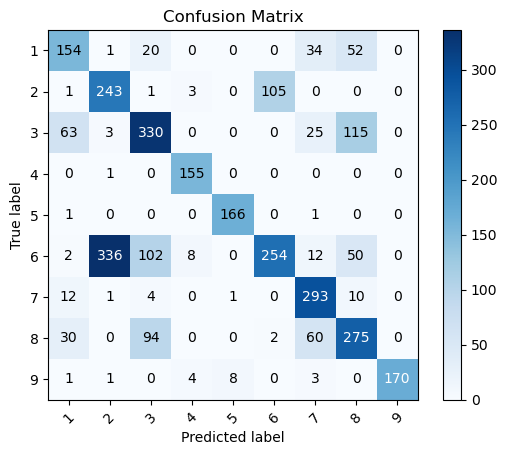

Classification Report:
              precision    recall  f1-score   support

         1.0       0.58      0.59      0.59       261
         2.0       0.41      0.69      0.52       353
         3.0       0.60      0.62      0.61       536
         4.0       0.91      0.99      0.95       156
         5.0       0.95      0.99      0.97       168
         6.0       0.70      0.33      0.45       764
         7.0       0.68      0.91      0.78       321
         8.0       0.55      0.60      0.57       461
         9.0       1.00      0.91      0.95       187

    accuracy                           0.64      3207
   macro avg       0.71      0.74      0.71      3207
weighted avg       0.66      0.64      0.63      3207

The success rate of the model is 0.6361085126286249


In [28]:
# Print evaluations
confusion_matrix_create(y_test, y_pred)

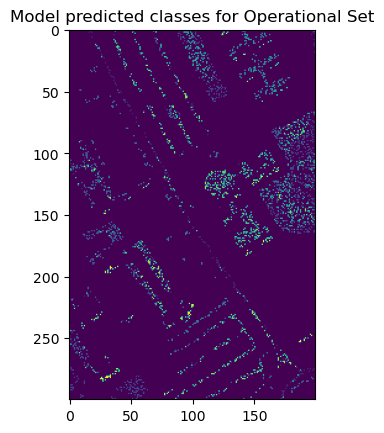

In [29]:
# print operation set predicted image
oper_set_map(NB_model,Operational_Set,HSI)

###  (ii) the minimum Euclidean distance classifier

In [30]:
# Create a method that performs the min eucl distance classifying, given a training and a test set.
def min_eucl_dist(X_train,y_train,X_test):
    # Find the mean of each class points based on training set
    label_means = np.zeros((9, 103))
    for label in range(1, 10):
        label_means[label - 1] = np.mean(X_train[y_train == label], axis=0)
    y_pred = np.zeros(X_test.shape[0])
    # For each point of test set find which class mean is the closest using eucl distance
    for i in range(X_test.shape[0]):
        index = -1
        min_dist = np.inf
        for j in range(9):
            dist = (X_test[i,:]-label_means[j,:])@(X_test[i,:]-label_means[j,:]).T
            if min_dist>dist:
                min_dist = dist
                index = j+1
        y_pred[i] = index
    return y_pred

In [31]:
# Create 10 different cuts for the training and test sets (10 fold cross validation) and calculate mean and std of the accuracies
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
for fold_idx, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        X_train_f, X_test_f = X_train[train_index], X_train[test_index]
        y_train_f, y_test_f = y_train[train_index], y_train[test_index]
        # Use x_test to predict y labels
        y_pred_f = min_eucl_dist(X_train_f,y_train_f,X_test_f)
        # Compare y_pred with real values
        accuracies.append(accuracy_score(y_test_f, y_pred_f))

accuracies = np.array(accuracies)

# Calculate mean and standard deviation using numpy
mean_value = np.mean(accuracies)
std_deviation = np.std(accuracies)
print(f"Validation Score Mean: {mean_value}\nValidation Error Mean: {1-mean_value}\nValidation Score Variance: {std_deviation}")

Validation Score Mean: 0.567272952600347
Validation Error Mean: 0.43272704739965295
Validation Score Variance: 0.0184060932066571


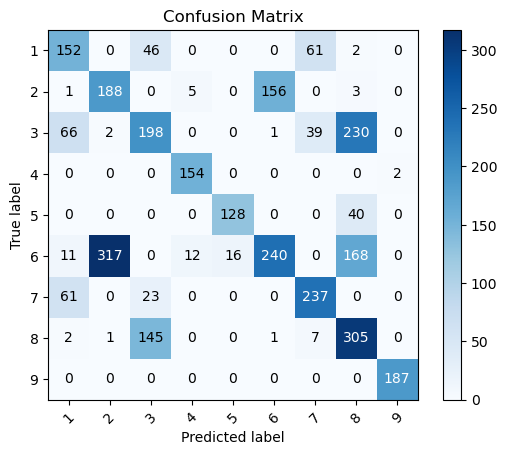

Classification Report:
              precision    recall  f1-score   support

         1.0       0.52      0.58      0.55       261
         2.0       0.37      0.53      0.44       353
         3.0       0.48      0.37      0.42       536
         4.0       0.90      0.99      0.94       156
         5.0       0.89      0.76      0.82       168
         6.0       0.60      0.31      0.41       764
         7.0       0.69      0.74      0.71       321
         8.0       0.41      0.66      0.50       461
         9.0       0.99      1.00      0.99       187

    accuracy                           0.56      3207
   macro avg       0.65      0.66      0.64      3207
weighted avg       0.58      0.56      0.55      3207

The success rate of the model is 0.5578422201434362


In [32]:
y_pred = min_eucl_dist(X_train,y_train,X_test)
confusion_matrix_create(y_test, y_pred)

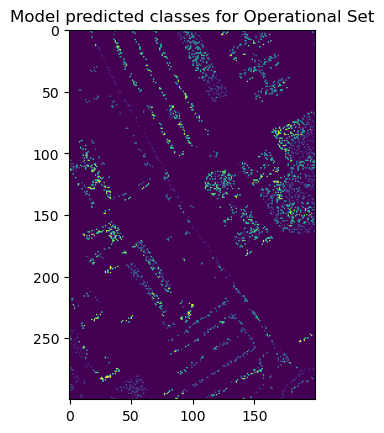

In [33]:
op_set_classes = np.zeros((300,200))
for i in range(300):
    for j in range(200):
        if (Operational_Set[i,j] != 0):
            op_set_classes[i,j] = min_eucl_dist(X_train,y_train,HSI[i,j,:].reshape(1, -1))
fig = plt.figure()
plt.imshow(op_set_classes)
plt.title('Model predicted classes for Operational Set')
plt.show()            

### (iii) the k-nearest neighbor classifier

In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
model = MultinomialNB()
mean_knn,std_knn = cross_validate_model(knn,X_train,y_train)
print(f"Validation Score Mean: {mean_knn}\nValidation Error Mean: {1-mean_knn}\nValidation Score Variance: {std_knn}")

Validation Score Mean: 0.8821504075116275
Validation Error Mean: 0.11784959248837246
Validation Score Variance: 0.014196261305502349


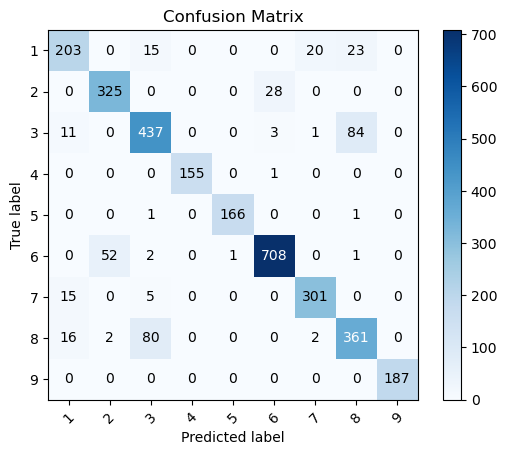

Classification Report:
              precision    recall  f1-score   support

         1.0       0.83      0.78      0.80       261
         2.0       0.86      0.92      0.89       353
         3.0       0.81      0.82      0.81       536
         4.0       1.00      0.99      1.00       156
         5.0       0.99      0.99      0.99       168
         6.0       0.96      0.93      0.94       764
         7.0       0.93      0.94      0.93       321
         8.0       0.77      0.78      0.78       461
         9.0       1.00      1.00      1.00       187

    accuracy                           0.89      3207
   macro avg       0.90      0.90      0.90      3207
weighted avg       0.89      0.89      0.89      3207

The success rate of the model is 0.8864982850015591


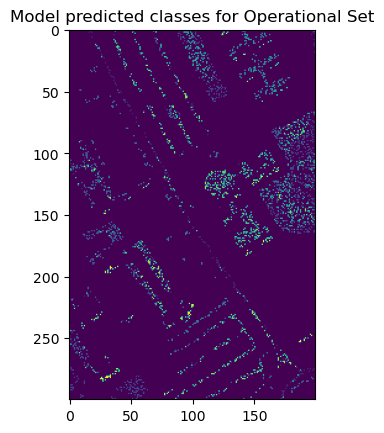

In [35]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
confusion_matrix_create(y_test, y_pred)
oper_set_map(knn,Operational_Set,HSI)

###  (iv) the Bayesian classifier

In [36]:
# Method for calculating mean and cov matrix of the points of each of the 9 labels, using the training set
def stats(X_train,y_train):
    means = np.zeros((9,103))
    covariance_list = []
    for i in range(9):
        means[i,:] = np.mean(X_train[y_train == i+1],axis=0)
        covariance_list.append(np.cov(X_train[y_train == i+1], rowvar=False))
    return means, covariance_list

In [37]:
# Method for calculating the probability of a point X belonging to class i with mean: mean and cov matrix: S
def proba(X,mean,S):
    k = len(mean)
    pdf = (1 / np.sqrt((2 * np.pi) ** k) * np.linalg.det(S)) * np.exp(-0.5 * (X - mean).T @ np.linalg.inv(S) @ (X - mean))
    return pdf

In [38]:
# Method used to perform the bayesian classifier
def Bayes(X_train, y_train, X_test):
    y_pred = np.zeros(X_test.shape[0])
    count = [0,0,0,0,0,0,0,0,0]
    total = y_train.shape[0]
    for i in range(y_train.shape[0]):
        count[int(y_train[i])-1] += 1
    # Find the prior probabilities of each class ni/n
    prior = [number / total for number in count]
    means, covariance_list = stats(X_train,y_train)
    for i in range(X_test.shape[0]):
        max_prob = -1
        index = -1
        for j in range(9):
            # Probability of X from test set belonging to class j+1
            prob = proba(X_test[i,:],means[j,:],covariance_list[j])
            # P(ωi)*p(x|ωi)
            prob2 = prob*prior[j]
            # keep max prob2 class and classify point to it
            if prob2 > max_prob:
                max_prob = prob2
                index = j+1
        y_pred[i] = index
    return y_pred

In [39]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
for fold_idx, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        X_train_f, X_test_f = X_train[train_index], X_train[test_index]
        y_train_f, y_test_f = y_train[train_index], y_train[test_index]
        y_pred_f = Bayes(X_train_f,y_train_f,X_test_f)
        accuracies.append(accuracy_score(y_test_f, y_pred_f))

accuracies = np.array(accuracies)
mean_value = np.mean(accuracies)
std_deviation = np.std(accuracies)
print(f"Validation Score Mean: {mean_value}\nValidation Error Mean: {1-mean_value}\nValidation Score Variance: {std_deviation}")

Validation Score Mean: 0.49025811499749705
Validation Error Mean: 0.509741885002503
Validation Score Variance: 0.012472707291383311


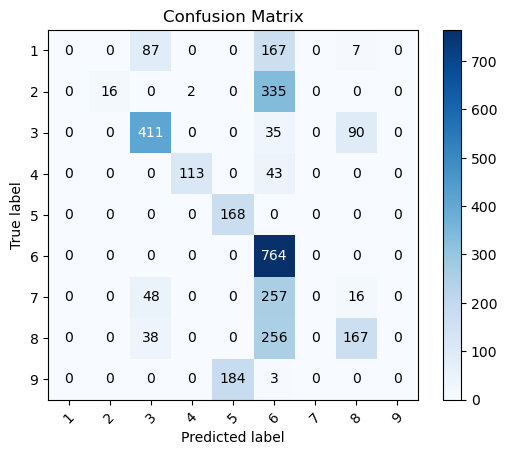

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       261
         2.0       1.00      0.05      0.09       353
         3.0       0.70      0.77      0.73       536
         4.0       0.98      0.72      0.83       156
         5.0       0.48      1.00      0.65       168
         6.0       0.41      1.00      0.58       764
         7.0       0.00      0.00      0.00       321
         8.0       0.60      0.36      0.45       461
         9.0       0.00      0.00      0.00       187

    accuracy                           0.51      3207
   macro avg       0.46      0.43      0.37      3207
weighted avg       0.48      0.51      0.41      3207

The success rate of the model is 0.5110695353913315


In [40]:
y_pred = Bayes(X_train,y_train,X_test)
confusion_matrix_create(y_test, y_pred)

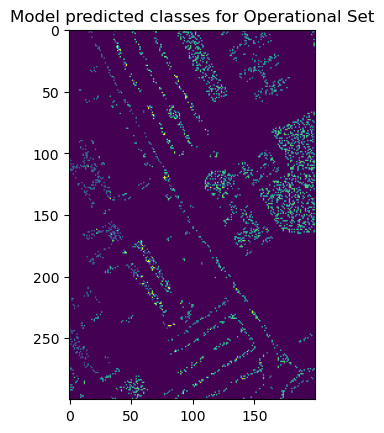

In [41]:
op_set_classes = np.zeros((300,200))
for i in range(300):
    for j in range(200):
        if (Operational_Set[i,j] != 0):
            op_set_classes[i,j] = Bayes(X_train,y_train,HSI[i,j,:].reshape(1, -1))
fig = plt.figure()
plt.imshow(op_set_classes)
plt.title('Model predicted classes for Operational Set')
plt.show()     

## (B) Compare the results of the classifiers and comment on them

To successfully compare the classifiers, we firstly need to rank the by their success rate. The best performing classifier was k-nn (3-nn) with a success rate of 88%. Following was the Naive-Bayes with 63%, Minimum Euclidean Distance with 55% and the Bayesian classifier with 51%. Firstly, we could expect the bad performanes of Bayes as we used normal distribution to model each class something that wasn't true for every class. We saw that this worked well for classes 3,4,5 which had a high f1-score, but wasn't true for most classes that didnt perform well. We can also see that many points were assigned to class 6 (probably because of its high ni and prior probability). The Minimum Euclidean Distance classifier assigned wrongly many points to classes 1,2,8 where we could observe over 300 points that belonged to many classes being wrongly assigned. For the Naive-Bayes classifier we can see again that classes 1,2,8 were problematic, as many points from other classes where wrongly assigned to them. The k-nn algorithm worked really well, with slight misassignments to classes 2,3,8. In general we can see that most of the confusion was because our classifiers assigned many materials to trees or meadows. Our best classifier confused Asphalt to be meadows,tiles to be trees and meadaws to be Asphalt. If we look closely those were the most significant confusions for the other classifiers to (in a larger scale). The k-nn managed to avoid that on a certain scale by looking at the classes of the closest points of the training set. To sum up, k-nn (k=3) was our best performing classifier with 88 success rate, but confusing asphalt with meadaws (and the opposite) in some cases and tiles to trees.

## Part 3 (combination)


If we look closely to the abundance maps of our best method (LS-NN) we can see that the map for the material 3 (asphalt) is very similar (almost the same) to the one of material 8 (meadows). Also almost all our classifying error from every classifier was the outcome of the confussion of these 2 materials in the classification process. What we understand from this, is that these two materials have very similar spectral properties, and are be very oftenly confused to be the same from a picture. The same result was seen for tiles and trees. For these case, the abundance maps had a common distinct area on the right of the map. That's why when tiles came up they got confused with trees, as for this area the pixels are very similar for both materials. The reason why trees weren't confused much for tiles is that in the abundance map for trees there is a distinct area on the top that doesn't exist for tiles. That could be the reason that tha classifiers were able to be precise with the class of trees. All the other materials had distinct properties on their abundance maps something that translated to better classification.